In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re


In [2]:
n_rows = 5000
n_signal_variables = 10
n_noise_variables = 100
n_levels = 500

In [3]:
d = pandas.DataFrame({"y":0.01*numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.uniform(low=-10, high=10, size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,noise_90,noise_91,noise_92,noise_93,noise_94,noise_95,noise_96,noise_97,noise_98,noise_99
0,-7.691955,level_60,level_326,level_85,level_381,level_322,level_93,level_269,level_143,level_79,...,level_305,level_30,level_382,level_174,level_316,level_158,level_347,level_77,level_135,level_47
1,-5.511454,level_476,level_267,level_380,level_36,level_293,level_191,level_379,level_419,level_311,...,level_490,level_171,level_415,level_107,level_286,level_71,level_381,level_252,level_275,level_187
2,18.913240,level_201,level_394,level_401,level_372,level_355,level_441,level_89,level_319,level_24,...,level_210,level_305,level_116,level_452,level_321,level_342,level_98,level_463,level_5,level_356
3,-26.369847,level_331,level_440,level_467,level_335,level_494,level_150,level_430,level_440,level_364,...,level_360,level_449,level_486,level_375,level_62,level_56,level_475,level_362,level_384,level_278
4,-19.236629,level_30,level_90,level_234,level_12,level_386,level_112,level_247,level_212,level_211,...,level_45,level_462,level_111,level_311,level_427,level_204,level_215,level_93,level_351,level_463


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,17.916121,6.139474,-0.082421,3.945687,5.172160,7.551665,-5.025162,-8.424200,10.006229,5.446534,...,1.955374,3.451981,-6.128959,-8.676492,4.685700,0.282669,-12.915192,-1.127045,-2.864921,-0.536947
1,-10.969660,5.370313,-2.663475,-13.138140,-9.797871,-8.890331,5.838371,-5.519551,-5.132524,-3.270645,...,-17.907292,-2.811150,-11.870388,1.034432,-8.385721,-8.262094,0.779957,-12.608869,-6.469958,-1.136113
2,-2.007537,-12.017086,10.723995,-10.913346,-8.095964,-5.670343,-14.205233,-12.556643,7.526265,-0.541811,...,-4.448059,-1.069223,-2.023602,5.315192,0.260170,-5.660187,-5.715905,-4.423480,-3.245311,9.809857
3,-11.869605,13.582569,5.575107,5.880748,-4.378192,-3.506975,-0.825641,-5.949608,-4.234259,-10.402886,...,-4.014439,2.623950,22.501199,13.294815,-1.900968,-6.625153,9.784230,-2.096751,-7.848580,-9.936256
4,-2.182300,-5.634784,-2.060156,2.089805,-13.831448,-4.571443,-12.835923,-7.770014,-10.957410,-10.318596,...,7.404361,0.371953,2.334208,-8.918259,-4.367726,-10.802509,2.440443,-0.201033,-15.133994,-9.936256


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,12.592367,4.028111,-0.065919,1.437358,1.686585,6.243510,-4.897752,-4.628358,8.818341,4.742842,...,1.423679,2.976474,-4.015362,-6.535443,1.592588,0.207287,-11.455863,-0.992105,-1.082573,-0.339782
1,-6.118252,0.790694,-1.505437,-7.695657,-6.005688,-4.236724,4.084472,-4.695395,-2.810980,-0.349328,...,-9.728235,-1.476881,-8.563714,0.632755,-4.814118,-3.979105,0.546707,-7.499019,-4.110299,-0.350343
2,-1.156530,-9.506150,5.205708,-5.973441,-7.250612,-4.692745,-8.914342,-7.493649,6.015831,-0.387445,...,-2.090169,-0.476208,-0.748976,2.354048,0.146227,-3.786012,-1.702187,-2.060262,-0.872014,3.142283
3,-10.014277,4.716197,3.374255,4.547424,-3.929951,-1.783427,-0.484670,-5.060496,-3.057798,-7.987664,...,-3.056525,1.854502,3.023835,4.750267,-1.348089,-5.091200,4.803840,-1.414777,-4.698191,-5.758645
4,-1.327369,-3.648352,-1.494535,1.597819,-12.771214,-3.297363,-8.024510,-4.306467,-5.599507,-8.763113,...,3.650910,0.265667,1.222608,-7.782170,-2.601121,-8.219825,1.130050,-0.121653,-8.054471,-5.758645


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,14.427786,3.739276,-0.658382,2.390348,1.978937e+00,7.602939,-4.706354,-0.448304,8.122743,1.534835,...,1.311689,5.322810,-5.109052,-8.558488,21.751018,0.962751,-12.883989,2.882021,2.399650,0.000000
1,-15.319799,2.518541,2.528809,0.000000,-5.441504e+00,-0.111692,9.728454,-3.528357,-1.660418,0.000000,...,-5.023843,3.342878,-6.399289,2.258262,-7.734483,-1.087844,3.504515,-4.982241,-1.155588,2.451267
2,0.490730,-5.917653,10.448051,-4.624115,-6.765076e+00,-5.192962,-0.880729,-4.989288,9.112360,-0.299189,...,0.078394,1.396210,0.000000,5.633126,2.326719,1.817633,-0.626225,-2.383383,0.000000,23.963442
3,0.000000,2.873731,12.139638,10.114728,6.938894e-18,-1.266701,1.774018,-9.950343,-10.479823,-7.885761,...,-2.443191,7.893325,4.152837,6.168588,3.168705,-2.268746,6.757799,0.959953,-7.975587,-6.484079
4,0.340850,-0.245437,0.163315,3.626249,-1.344082e+01,0.530901,-6.306254,0.008862,-4.316950,-8.560518,...,3.461965,0.000000,2.170577,-7.321196,2.277950,-5.668091,7.881588,0.914368,-38.277080,-4.536303


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.527407,0.500457,0.165719,0.215927,False
1,var_1_impact_code,0.518079,0.489627,0.133189,0.188755,False
2,var_2_impact_code,0.534407,0.506746,0.179586,0.186598,False
3,var_3_impact_code,0.535633,0.509706,0.175539,0.192121,False
4,var_4_impact_code,0.530090,0.506327,0.161039,0.132163,False
5,var_5_impact_code,0.524541,0.497239,0.162465,0.137573,False
6,var_6_impact_code,0.538726,0.513126,0.190865,0.147807,False
7,var_7_impact_code,0.523928,0.495596,0.154609,0.173009,False
8,var_8_impact_code,0.548499,0.518875,0.206670,0.195658,False
9,var_9_impact_code,0.543088,0.514724,0.173815,0.195038,False


(0.8229472237579503, 2.7947182733279386e-28)


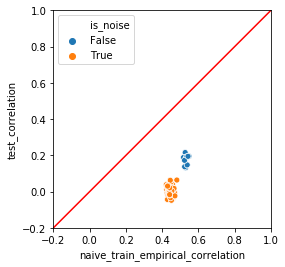

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8219468736531501, 3.682222970443372e-28)


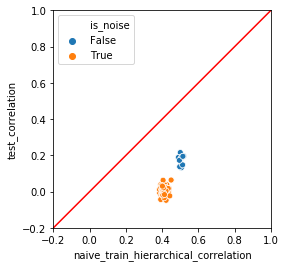

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.7940514852403314, 4.286892888510028e-25)


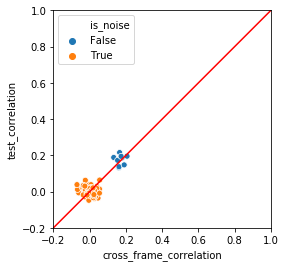

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
105,noise_95_impact_code,impact_code,True,True,0.023216,0.245622,110.0,False
106,noise_96_impact_code,impact_code,True,True,0.018677,0.350285,110.0,False
107,noise_97_impact_code,impact_code,True,True,-0.014190,0.477954,110.0,False
108,noise_98_impact_code,impact_code,True,True,-0.026231,0.189554,110.0,False
109,noise_99_impact_code,impact_code,True,True,0.023908,0.231822,110.0,False


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code',
 'var_1_impact_code',
 'var_2_impact_code',
 'var_3_impact_code',
 'var_4_impact_code',
 'var_5_impact_code',
 'var_6_impact_code',
 'var_7_impact_code',
 'var_8_impact_code',
 'var_9_impact_code',
 'noise_27_impact_code',
 'noise_50_impact_code',
 'noise_74_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,-7.691955,-16.226617,-11.202184,-2.560651,-2.895382
1,18.913240,7.069450,5.065660,0.538638,2.207906
2,12.893416,13.610395,8.159594,-0.527021,0.785301
3,38.294158,18.091258,25.871914,1.867908,5.443736
4,-2.891451,-1.700975,-1.412257,1.655929,3.455735


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

3.163081702267866


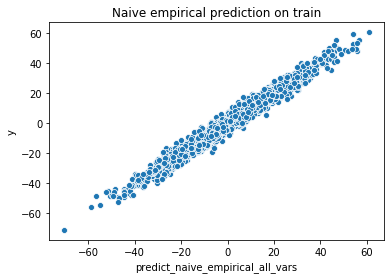

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

4.790265544978093


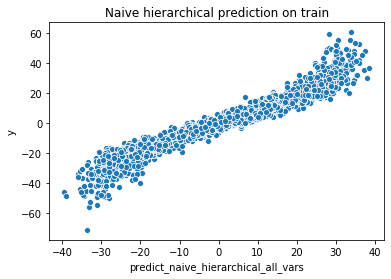

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

15.246864998465385


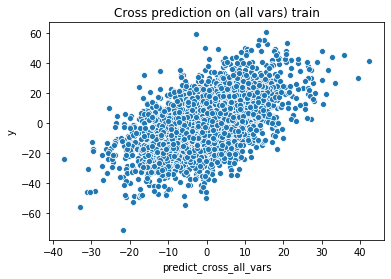

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

15.58521825437252


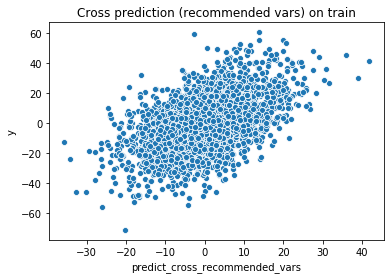

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

17.60729635446895


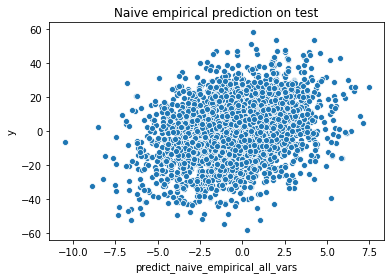

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

17.280626904292717


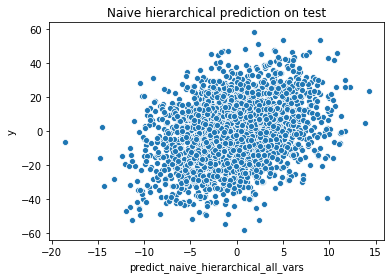

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

15.73202717374132


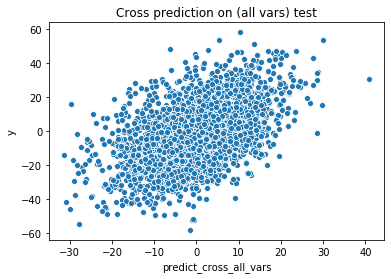

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

15.236880102993034


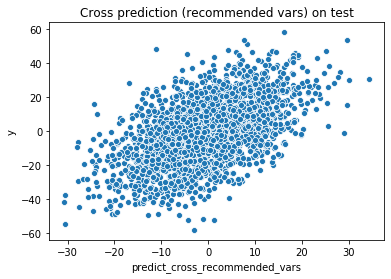

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf1 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     718.1
Date:                Fri, 26 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:43:24   Log-Likelihood:                -6433.9
No. Observations:                2503   AIC:                         1.309e+04
Df Residuals:                    2392   BIC:                         1.374e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1809      0.065     -2.798      0.005      -0.308      -0.054
var_0_impact_code        0.0603      0.008      7.608      0.000       0.045       0.076
var_1_impact_code        0.0697      0.008      8.691      0.000       0.054       0.085
var_2_impact_code        0.0538      0.008      6.816      0.000       0.038       0.069
var_3_impact_code        0.0640      0.008      8.168      0.000       0.049       0.079
var_4_impact_code        0.0702      0.008      8.887      0.000       0.055       0.086
var_5_impact_code        0.0592      0.008      7.427      0.000       0.044       0.075
var_6_impact_code        0.0677      0.008      8.624      0.000       0.052       0.083
var_7_impact_code        0.0651      0.008      8.097      0.000       0.049       0.081
var_8_impact_code        0.0641      0.008      8.238      0.000       0.049       0.079
var_9_impact_code        0.0720      0.008      9.234      0.000       0.057       0.087
noise_0_impact_code      0.0217      0.009      2.441      0.015       0.004       0.039
noise_1_impact_code      0.0412      0.009      4.673      0.000       0.024       0.059
noise_2_impact_code      0.0348      0.009      3.834      0.000       0.017       0.053
noise_3_impact_code      0.0279      0.009      3.015      0.003       0.010       0.046
noise_4_impact_code      0.0373      0.009      4.199      0.000       0.020       0.055
noise_5_impact_code      0.0257      0.009      2.945      0.003       0.009       0.043
noise_6_impact_code      0.0481      0.009      5.405      0.000       0.031       0.066
noise_7_impact_code      0.0474      0.009      5.239      0.000       0.030       0.065
noise_8_impact_code      0.0305      0.009      3.383      0.001       0.013       0.048
noise_9_impact_code      0.0328      0.009      3.645      0.000       0.015       0.050
noise_10_impact_code     0.0200      0.009      2.260      0.024       0.003       0.037
noise_11_impact_code     0.0407      0.009      4.621      0.000       0.023       0.058
noise_12_impact_code     0.0467      0.009      5.278      0.000       0.029       0.064
noise_13_impact_code     0.0462      0.009      5.237      0.000       0.029       0.064
noise_14_impact_code     0.0338      0.009      3.878      0.000       0.017       0.051
noise_15_impact_code     0.0314      0.009      3.525      0.000       0.014       0.049
noise_16_impact_code     0.0508      0.009      5.565      0.000       0.033       0.069
noise_17_impact_code     0.0494      0.009      5.492      0.000       0.032       0.067
noise_18_impact_code     0.0505      0.009      5.459      0.000       0.032       0.069
noise_19_impact_code     0.0508      0.009      5.710      0.000       0.033       0.068
noise_20_impact_code     0.0346      0.009      3.919    

In [38]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_naive_empirical_all_vars"])

0.9706077279444247

In [39]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_naive_empirical_all_vars"])

0.06537362088955645

In [40]:
smf2 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     10.10
Date:                Fri, 26 Jul 2019   Prob (F-statistic):          2.42e-130
Time:                        12:43:25   Log-Likelihood:                -10371.
No. Observations:                2503   AIC:                         2.096e+04
Df Residuals:                    2392   BIC:                         2.161e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1087      0.319      0.340      0.734      -0.518       0.735
var_0_impact_code        0.4785      0.048     10.067      0.000       0.385       0.572
var_1_impact_code        0.3502      0.046      7.601      0.000       0.260       0.441
var_2_impact_code        0.4225      0.047      9.072      0.000       0.331       0.514
var_3_impact_code        0.4229      0.046      9.201      0.000       0.333       0.513
var_4_impact_code        0.3993      0.047      8.582      0.000       0.308       0.491
var_5_impact_code        0.4077      0.047      8.715      0.000       0.316       0.499
var_6_impact_code        0.4654      0.045     10.323      0.000       0.377       0.554
var_7_impact_code        0.4474      0.048      9.364      0.000       0.354       0.541
var_8_impact_code        0.4599      0.044     10.501      0.000       0.374       0.546
var_9_impact_code        0.4256      0.045      9.508      0.000       0.338       0.513
noise_0_impact_code      0.1045      0.055      1.891      0.059      -0.004       0.213
noise_1_impact_code     -0.0170      0.057     -0.298      0.766      -0.129       0.095
noise_2_impact_code      0.0227      0.058      0.393      0.694      -0.091       0.136
noise_3_impact_code     -0.0237      0.060     -0.393      0.694      -0.142       0.094
noise_4_impact_code     -0.0389      0.058     -0.675      0.500      -0.152       0.074
noise_5_impact_code      0.0657      0.056      1.179      0.239      -0.044       0.175
noise_6_impact_code      0.0229      0.057      0.403      0.687      -0.088       0.134
noise_7_impact_code     -0.0157      0.058     -0.272      0.786      -0.129       0.097
noise_8_impact_code      0.0085      0.058      0.147      0.883      -0.104       0.121
noise_9_impact_code     -0.0816      0.055     -1.483      0.138      -0.189       0.026
noise_10_impact_code    -0.0059      0.055     -0.109      0.914      -0.113       0.101
noise_11_impact_code     0.0081      0.057      0.144      0.886      -0.103       0.119
noise_12_impact_code     0.0851      0.056      1.520      0.129      -0.025       0.195
noise_13_impact_code     0.0029      0.054      0.054      0.957      -0.104       0.110
noise_14_impact_code     0.0416      0.056      0.743      0.458      -0.068       0.152
noise_15_impact_code     0.0670      0.053      1.253      0.210      -0.038       0.172
noise_16_impact_code    -0.0548      0.057     -0.968      0.333      -0.166       0.056
noise_17_impact_code    -0.0179      0.055     -0.325      0.745      -0.126       0.090
noise_18_impact_code    -0.1125      0.060     -1.888      0.059      -0.229       0.004
noise_19_impact_code     0.0701      0.054      1.310      0.190      -0.035       0.175
noise_20_impact_code     0.0671      0.056      1.207    

In [41]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_all_vars"])

0.31707431193268887

In [42]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_all_vars"])

0.2538570117064205

In [43]:
smf3 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[recommended_vars])).fit()
smf3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     76.85
Date:                Fri, 26 Jul 2019   Prob (F-statistic):          1.55e-171
Time:                        12:43:25   Log-Likelihood:                -10426.
No. Observations:                2503   AIC:                         2.088e+04
Df Residuals:                    2489   BIC:                         2.096e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0855      0.313      0.273      0.785      -0.528       0.699
var_0_impact_code        0.4679      0.047     10.022      0.000       0.376       0.559
var_1_impact_code        0.3695      0.045      8.151      0.000       0.281       0.458
var_2_impact_code        0.4386      0.046      9.602      0.000       0.349       0.528
var_3_impact_code        0.4369      0.045      9.669      0.000       0.348       0.525
var_4_impact_code        0.3955      0.046      8.639      0.000       0.306       0.485
var_5_impact_code        0.4258      0.046      9.267      0.000       0.336       0.516
var_6_impact_code        0.4642      0.044     10.440      0.000       0.377       0.551
var_7_impact_code        0.4604      0.047      9.814      0.000       0.368       0.552
var_8_impact_code        0.4759      0.043     11.052      0.000       0.391       0.560
var_9_impact_code        0.4213      0.044      9.588      0.000       0.335       0.507
noise_27_impact_code     0.0801      0.051      1.556      0.120      -0.021       0.181
noise_50_impact_code     0.1601      0.056      2.837      0.005       0.049       0.271
noise_74_impact_code     0.1064      0.053      2.016      0.044       0.003       0.210
==============================================================================
Omnibus:                        1.778   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.411   Jarque-Bera (JB):                1.813
Skew:                           0.064   Prob(JB):                        0.404
Kurtosis:                       2.966   Cond. No.                         7.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_recommended_vars"])

0.2864274812439196

In [45]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_recommended_vars"])

0.3000858289544819